## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---


In [25]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


In [27]:
dataset = nlp.load_dataset('emotion')

In [28]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [29]:
train = dataset['train']
test = dataset['test']
val = dataset['validation']

In [30]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]

  return tweets,labels

In [31]:
tweets,labels = get_tweet(train)

In [32]:
tweets[0],labels[0]

('i didnt feel humiliated', 'sadness')

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [34]:
tokenizer = Tokenizer(num_words=1000, oov_token='<UKN>')
tokenizer.fit_on_texts(tweets)

In [35]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [36]:
tweets[0]

'i didnt feel humiliated'

<function matplotlib.pyplot.show>

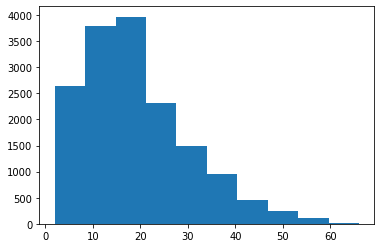

In [37]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths)
plt.show

In [38]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen = maxlen)
  return padded

In [39]:
padded_train_seq = get_sequences(tokenizer,tweets)

padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [40]:
classes = set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

<function matplotlib.pyplot.show>

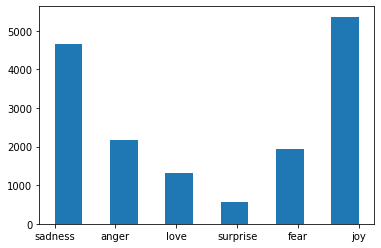

In [41]:
plt.hist(labels, bins = 11)
plt.show

In [42]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [43]:
class_to_index

{'anger': 0, 'fear': 3, 'joy': 4, 'love': 2, 'sadness': 1, 'surprise': 5}

In [44]:
index_to_class

{0: 'anger', 1: 'sadness', 2: 'love', 3: 'fear', 4: 'joy', 5: 'surprise'}

In [45]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [46]:
train_labels = names_to_ids(labels)

print(train_labels[0])

1


In [47]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000,16,input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = 'accuracy'
)

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [49]:
val_tweets, val_labels = get_tweet(val)

val_seq = get_sequences(tokenizer,val_tweets)
val_labels = names_to_ids(val_labels)

In [50]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [51]:
h = model.fit(
    padded_train_seq,train_labels,
    validation_data = (val_seq,val_labels),
    epochs = 20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 2)
    ]
)

Epoch 1/20
500/500 [==============================] - 32s 53ms/step - loss: 1.3636 - accuracy: 0.4689 - val_loss: 0.9747 - val_accuracy: 0.6530
Epoch 2/20
500/500 [==============================] - 26s 53ms/step - loss: 0.7564 - accuracy: 0.7343 - val_loss: 0.6346 - val_accuracy: 0.7780
Epoch 3/20
500/500 [==============================] - 24s 49ms/step - loss: 0.5408 - accuracy: 0.8103 - val_loss: 0.5273 - val_accuracy: 0.8185
Epoch 4/20
500/500 [==============================] - 36s 72ms/step - loss: 0.4277 - accuracy: 0.8486 - val_loss: 0.4456 - val_accuracy: 0.8430
Epoch 5/20
500/500 [==============================] - 25s 51ms/step - loss: 0.3686 - accuracy: 0.8673 - val_loss: 0.4431 - val_accuracy: 0.8445
Epoch 6/20
500/500 [==============================] - 35s 71ms/step - loss: 0.3260 - accuracy: 0.8835 - val_loss: 0.4290 - val_accuracy: 0.8620
Epoch 7/20
500/500 [==============================] - 26s 52ms/step - loss: 0.2979 - accuracy: 0.8910 - val_loss: 0.3964 - val_accuracy:

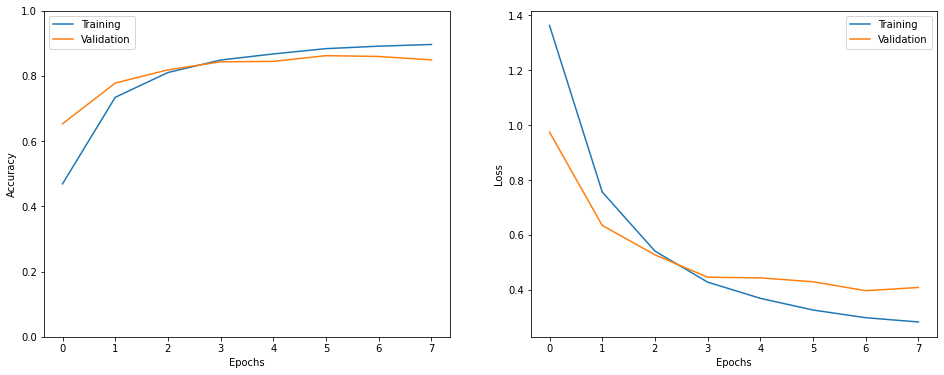

In [52]:
show_history(h)

In [53]:
test_tweets, test_labels = get_tweet(test)

test_seq = get_sequences(tokenizer,test_tweets)
test_labels = names_to_ids(test_labels)

In [54]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 14ms/step - loss: 0.3837 - accuracy: 0.8575


In [63]:
i = random.randint(0,len(test_labels)-1)

print('Sentence: ', test_tweets[i])
print('Emotion: ', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis = 0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion: ', pred_class)

Sentence:  i feel that he is gazing me and giving a naughty smile encouraging me to study more
Emotion:  love
Predicted Emotion:  love


In [66]:
preds = np.argmax(model.predict(test_seq), axis=-1)

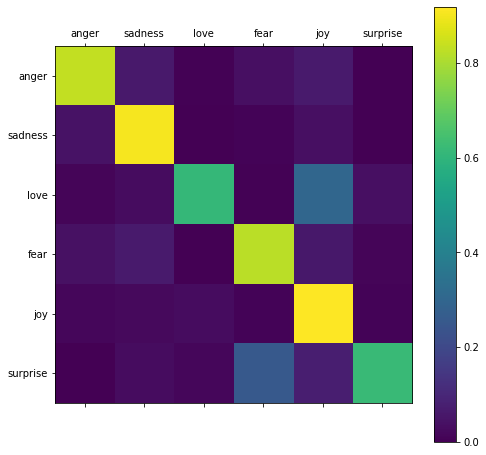

In [67]:
show_confusion_matrix(test_labels,preds,list(classes))